# Scan MERRA-2 atmospheric properties during one Year
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update April 25th 2018

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.

## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os

def default_proj_lib():
    proj_lib = os.getenv('PROJ_LIB')
    if proj_lib not in (None, 'PROJ_LIB'):
        return proj_lib
    try:
        import conda
    except ImportError:
        conda = None
    if conda is not None or os.getenv('CONDA_PREFIX') is None:
        conda_file_dir = conda.__file__
        conda_dir = conda_file_dir.split('lib')[0]
        proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
        if os.path.exists(proj_lib):
            return proj_lib
        return None
    return None


In [6]:
theprojlib=default_proj_lib()
print("The PROJ_LIB={}".format(theprojlib))

The PROJ_LIB=/Users/dagoret/anaconda2/share/proj/


In [7]:
#os.environ["PROJ_LIB"] = theprojlib
#print os.environ["PROJ_LIB"]

In [8]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [9]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [10]:
import h5py

In [11]:
import libGMAOMERRA2Data as merra2  # My own library

In [12]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [13]:
YEARNUM="2018"

In [14]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [15]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"
# For Simulation of CTIO atmosphere in May-Jun 2017
#HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"
# Data 2018
HDFEOS_ZOO_DIR="/sps/lsst/data/MERRA2/M2I1NXASM.5.12.4/"+YEARNUM
HDFEOS_ZOO_DIR="/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/"+YEARNUM

In [16]:
path=HDFEOS_ZOO_DIR

In [17]:
print path

/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018


### Here I describe the content of the input files

In [18]:
DATA_TAG=['PS','T10M','T2M','TO3','TOX','TQI','TQL','TQV','TS','U10M','U2M','U50M','V10M','V2M','V50M' ]

In [19]:
DATA_TITLE=['Surface Pressure',
            '10 meter air temperature',
            '2 meter air temperature',
            'total column ozone',
            'total column odd oxygen',
            'total precipitable ice water',
            'total precipitable liquid water',
            'total precipitable water vapor',
            'Surface Temperature skin',
            '10 meter eastward wind',
            '2 meter eastward wind',
            '50 meter eastward wind',
            '10 meter northward wind',
            '2 meter northward wind',
            '50 meter northward wind'
           ]

In [20]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [21]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # 

In [22]:
pandas_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [23]:
fits_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [24]:
hdf5_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.h5'

In [25]:
# 15 output files for figures
figfile_ps='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ps'+'.jpg'
figfile_t10='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t10'+'.jpg'
figfile_t2='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t2'+'.jpg'
figfile_to3='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_to3'+'.jpg'
figfile_tox='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tox'+'.jpg'
figfile_tqi='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqi'+'.jpg'
figfile_tql='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tql'+'.jpg'
figfile_tqv='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqv'+'.jpg'
figfile_ts='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ts'+'.jpg'
figfile_u10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u10m'+'.jpg'
figfile_u2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u2m'+'.jpg'
figfile_u50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u50m'+'.jpg'
figfile_v10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v10m'+'.jpg'
figfile_v2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v2m'+'.jpg'
figfile_v50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v50m'+'.jpg'

In [26]:
# 15 output files for figures
figfile_ps='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ps'+'.png'
figfile_t10='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t10'+'.png'
figfile_t2='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_t2'+'.png'
figfile_to3='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_to3'+'.png'
figfile_tox='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tox'+'.png'
figfile_tqi='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqi'+'.png'
figfile_tql='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tql'+'.png'
figfile_tqv='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_tqv'+'.png'
figfile_ts='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_ts'+'.png'
figfile_u10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u10m'+'.png'
figfile_u2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u2m'+'.png'
figfile_u50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_u50m'+'.png'
figfile_v10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v10m'+'.png'
figfile_v2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v2m'+'.png'
figfile_v50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_v50m'+'.png'

### Select where in the world

In [27]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [28]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [29]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [30]:
nc4_files[:5]

['MERRA2_400.inst1_2d_asm_Nx.20180101.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20180102.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20180103.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20180104.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20180105.nc4']

### 2.3) Select files of a given month

In [31]:
#keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2018.*'

In [32]:
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.'+YEARNUM+'.*'

In [33]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.inst1_2d_asm_Nx.2018.*


In [34]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [35]:
nc4_files2

array(['MERRA2_400.inst1_2d_asm_Nx.20180101.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180102.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180103.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180104.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180105.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180106.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180107.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180108.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180109.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180110.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180111.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180112.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180113.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180114.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180115.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180116.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180117.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180118.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180119.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20180120.nc4',


### 2.4) Sort files by increasing time

In [36]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [37]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [38]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]  # intermediate data series
ts4=[]
ts5=[]
ts6=[]  # intermediate data series
ts7=[]
ts8=[]
ts9=[]  # intermediate data series
ts10=[]
ts11=[]
ts12=[]
ts13=[]
ts14=[]

df_inst1_2d_asm_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    print file
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    

    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

        elif index==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index==5:
            ts5 = pd.Series(dt, index=time_rng)
        elif index==6:
            ts6 = pd.Series(dt, index=time_rng)
            
        elif index==7:
            ts7 = pd.Series(dt, index=time_rng)
        elif index==8:
            ts8 = pd.Series(dt, index=time_rng)
        elif index==9:
            ts9 = pd.Series(dt, index=time_rng)            
            
        elif index==10:
            ts10 = pd.Series(dt, index=time_rng)
        elif index==11:
            ts11 = pd.Series(dt, index=time_rng)
        elif index==12:
            ts12 = pd.Series(dt, index=time_rng) 
            
        elif index==13:
            ts13 = pd.Series(dt, index=time_rng) 
        elif index==14:
            ts14 = pd.Series(dt, index=time_rng) 
            
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5,
                       DATA_TAG[6]: ts6,                       

                       DATA_TAG[7]: ts7,
                       DATA_TAG[8]: ts8,
                       DATA_TAG[9]: ts9,
                       
                       DATA_TAG[10]: ts10,
                       DATA_TAG[11]: ts11,
                       DATA_TAG[12]: ts12,
                       DATA_TAG[13]: ts13,
                       DATA_TAG[14]: ts14 }, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180101.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180102.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180103.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180104.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180105.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180106.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180107.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180108.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180109.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180110.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180111.nc4

/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180402.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180403.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180404.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180405.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180406.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180407.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180408.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180409.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180410.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180411.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180412.nc4

/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180702.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180703.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180704.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180705.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180706.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180707.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180708.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180709.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180710.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180711.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20180712.nc4

/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181001.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181002.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181003.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181004.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181005.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181006.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181007.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181008.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181009.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181010.nc4
/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4/2018/MERRA2_400.inst1_2d_asm_Nx.20181011.nc4

### Concatenation

In [39]:
df_inst1_2d_asm_Nx=pd.concat(df_inst1_2d_asm_Nx)

In [40]:
df_inst1_2d_asm_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7296 entries, 2018-01-01 00:00:00 to 2018-10-31 23:00:00
Data columns (total 15 columns):
PS      7296 non-null float32
T10M    7296 non-null float32
T2M     7296 non-null float32
TO3     7296 non-null float32
TOX     7296 non-null float32
TQI     7296 non-null float32
TQL     7296 non-null float32
TQV     7296 non-null float32
TS      7296 non-null float32
U10M    7296 non-null float32
U2M     7296 non-null float32
U50M    7296 non-null float32
V10M    7296 non-null float32
V2M     7296 non-null float32
V50M    7296 non-null float32
dtypes: float32(15)
memory usage: 484.5 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [41]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_inst1_2d_asm_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in {}".format(DATA_TITLE[index],OBS_NAME,YEARNUM)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Pressure

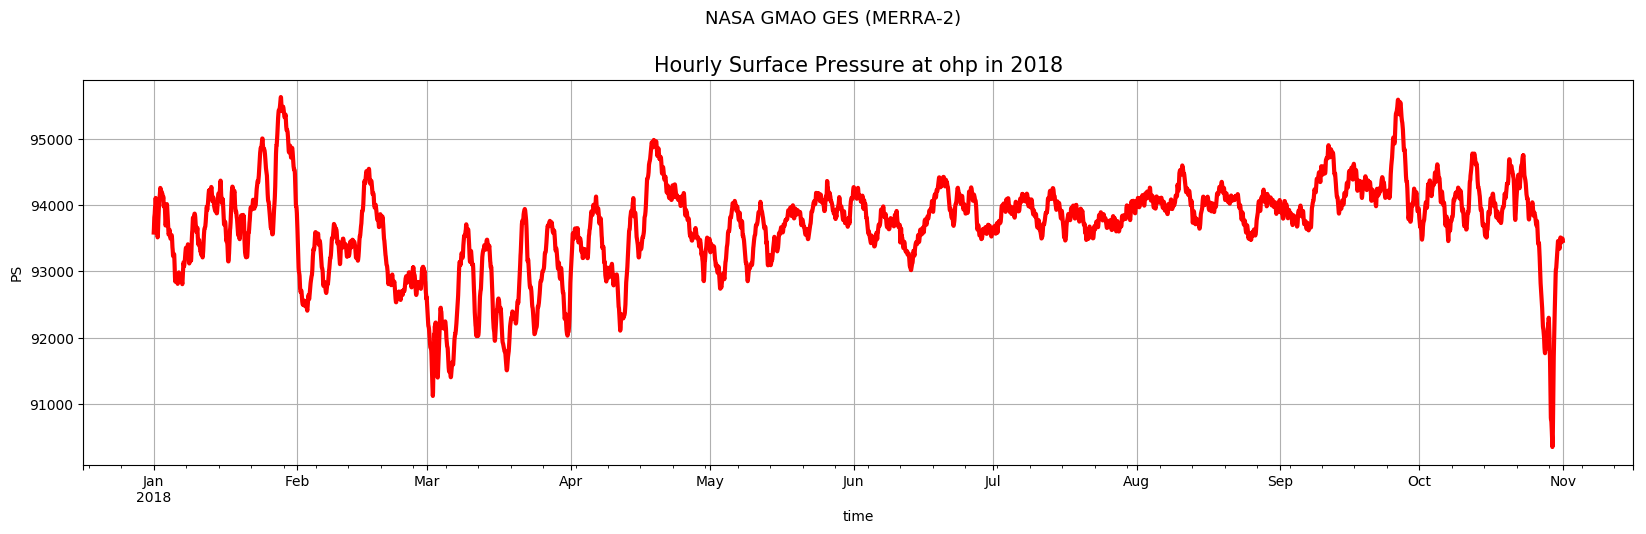

In [42]:
PlotTimeSeries(0,figfile_ps)

###  4.2)  T10
----------------

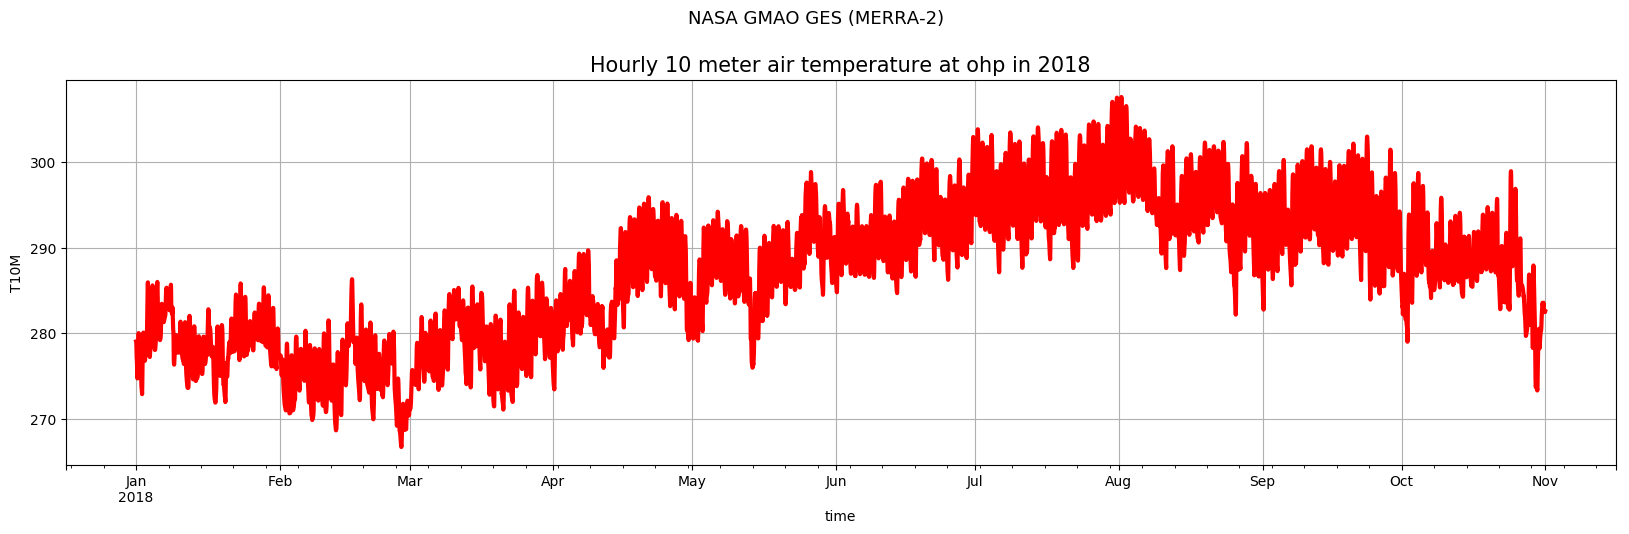

In [43]:
PlotTimeSeries(1,figfile_t10)

### 4.3) t2

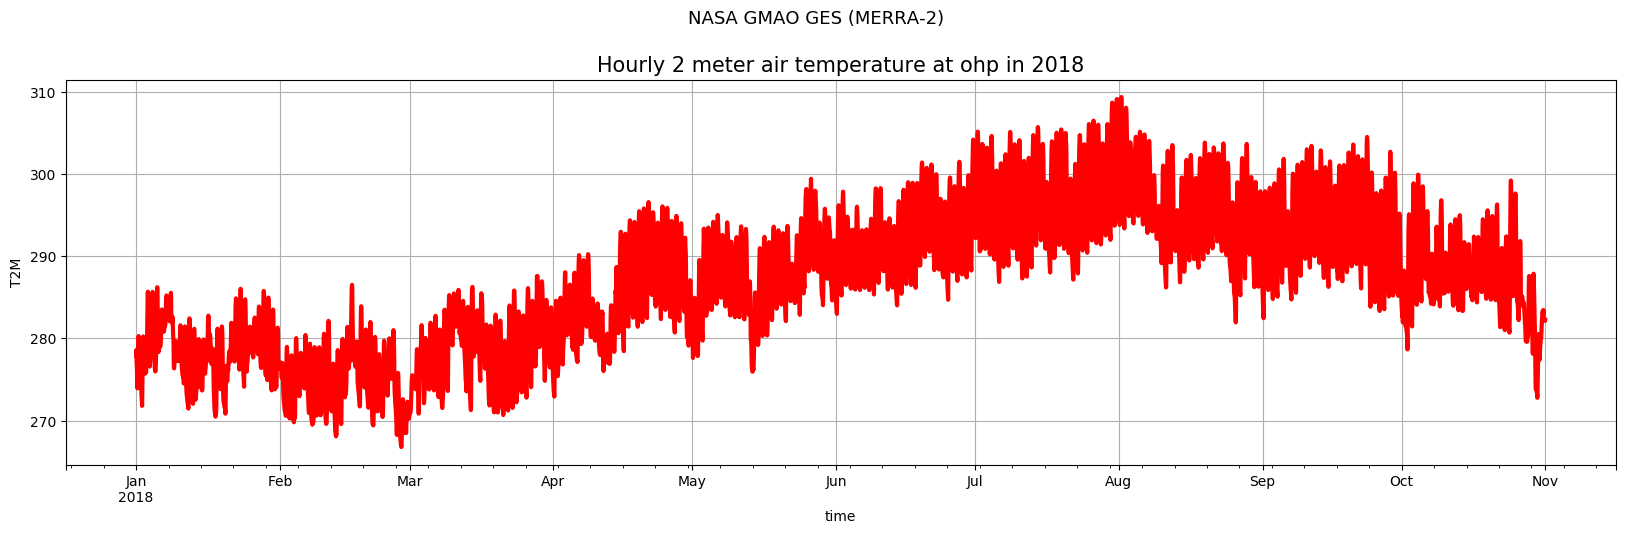

In [44]:
PlotTimeSeries(2,figfile_t2)

### 4.4) to3

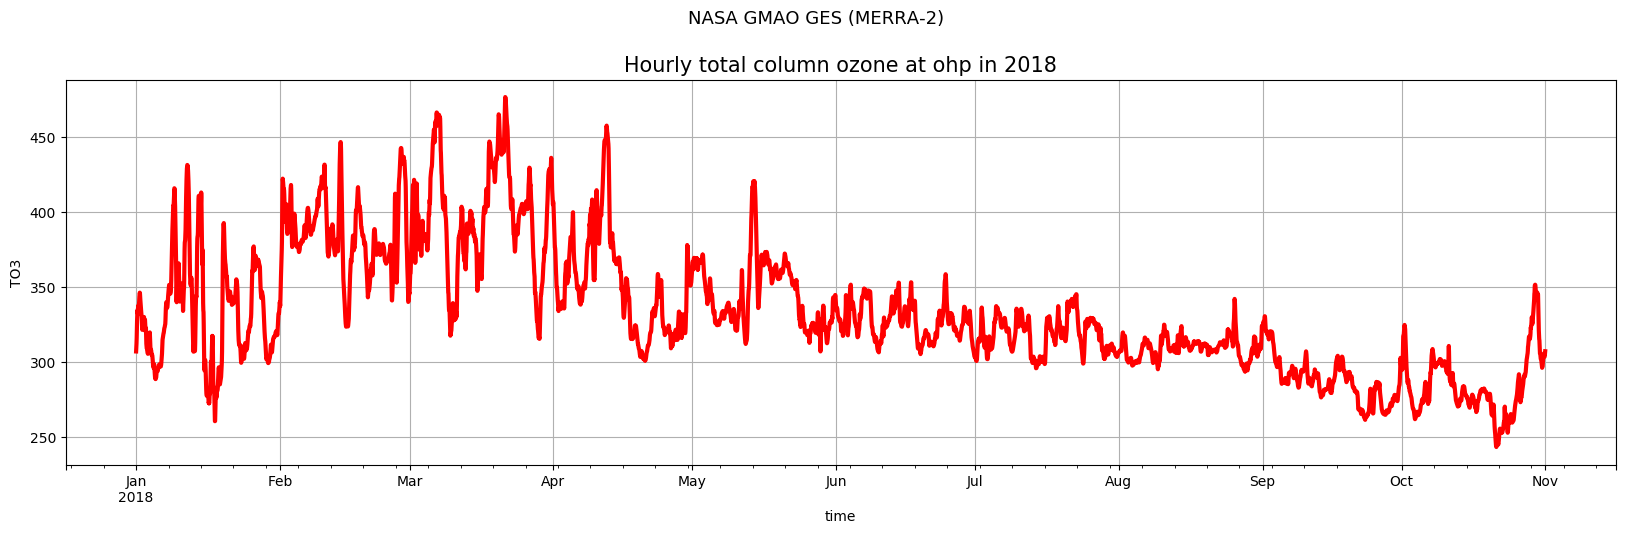

In [45]:
PlotTimeSeries(3,figfile_to3)

### 4.5) tox

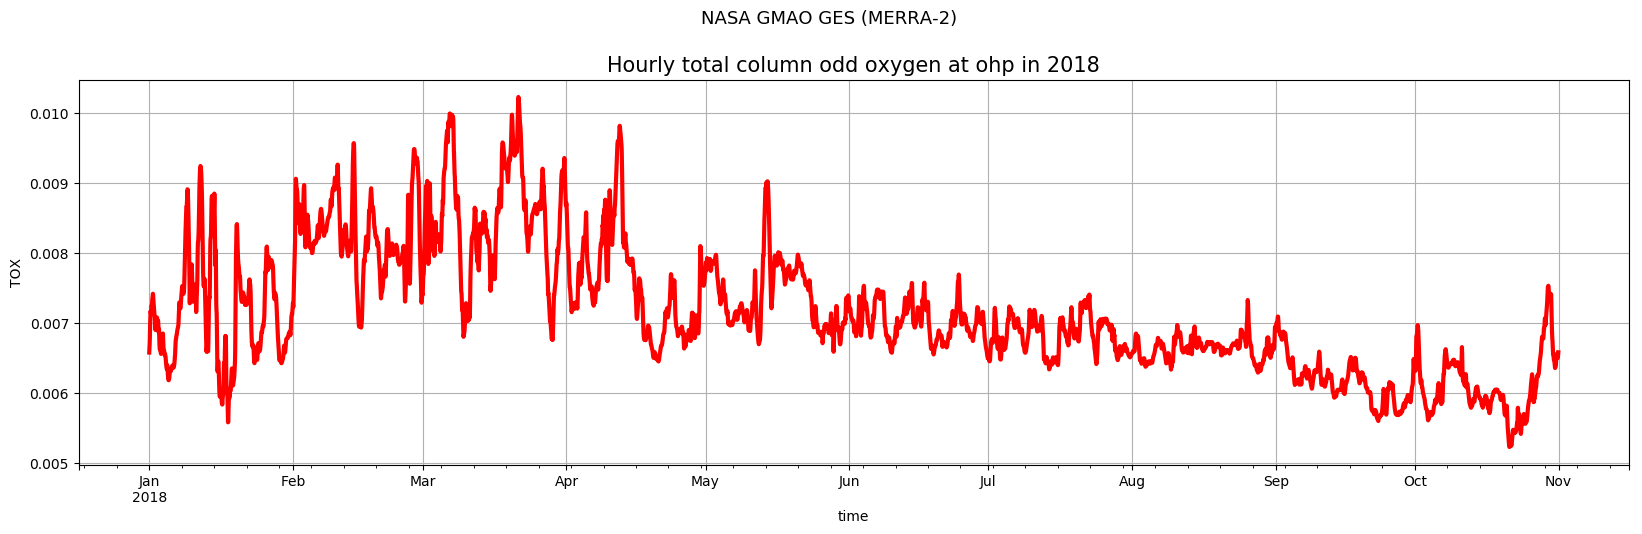

In [46]:
PlotTimeSeries(4,figfile_tox)

### 4.6 TQI

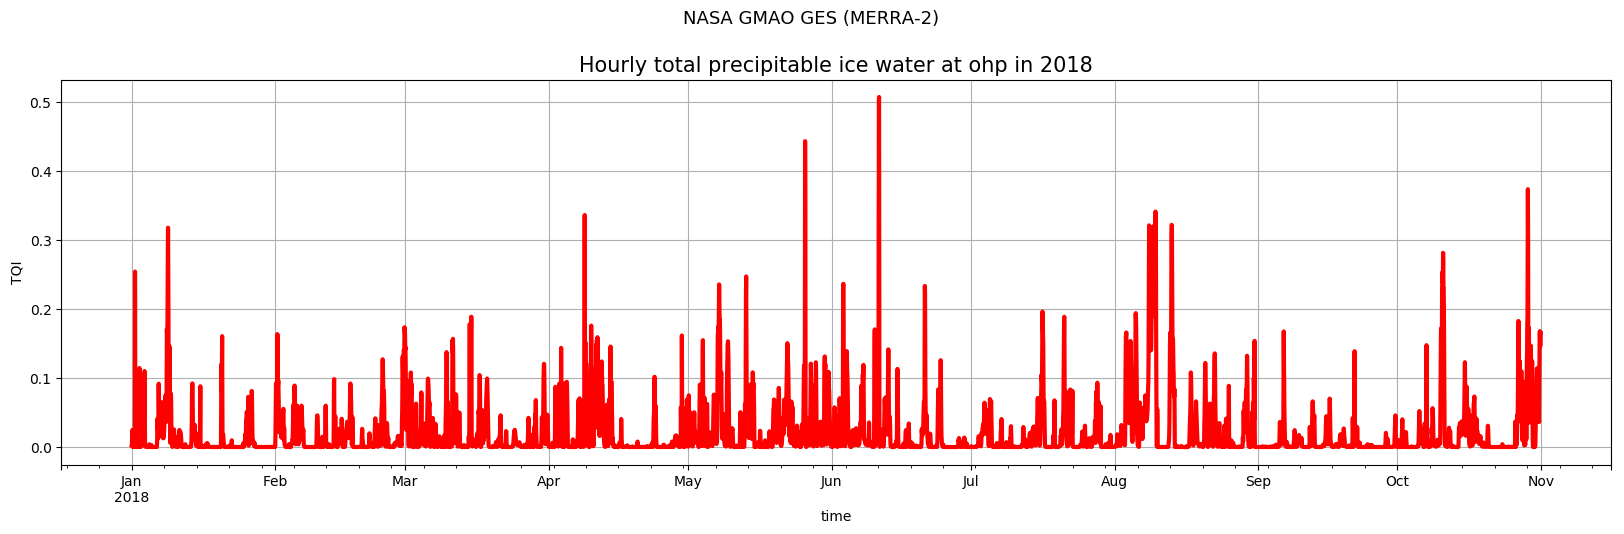

In [47]:
PlotTimeSeries(5,figfile_tqi)

### 4.7) TQL

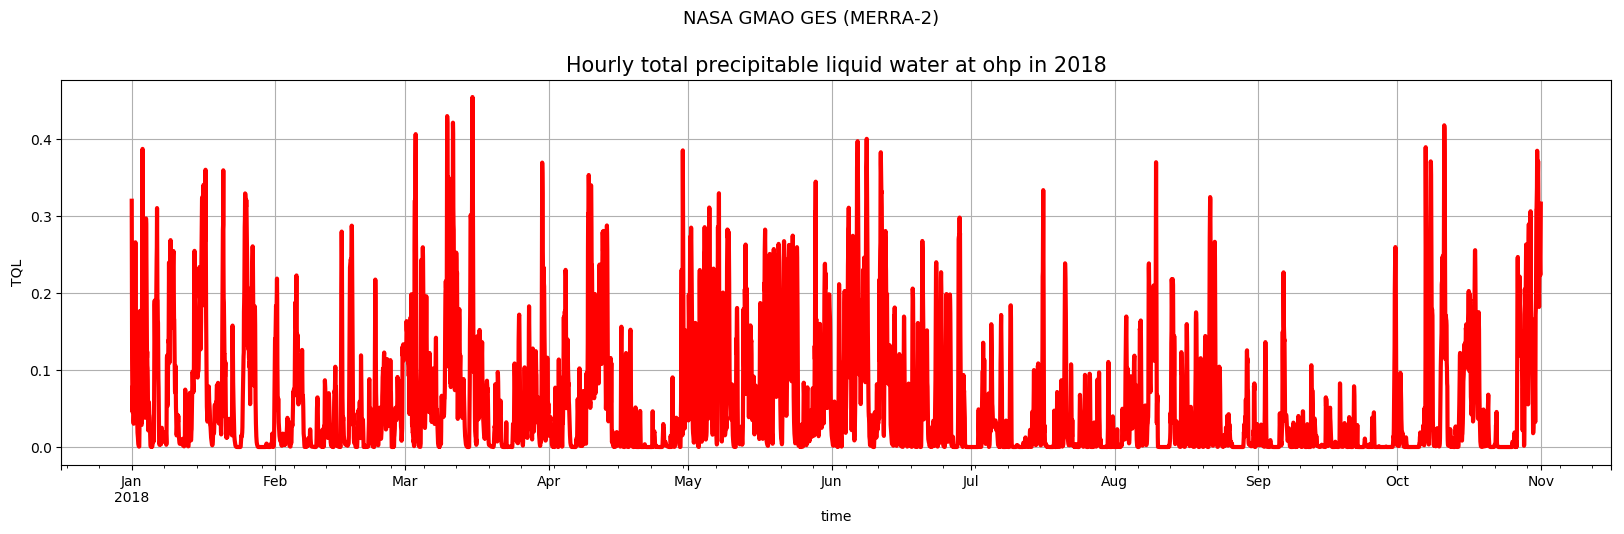

In [48]:
PlotTimeSeries(6,figfile_tql)

### TQV

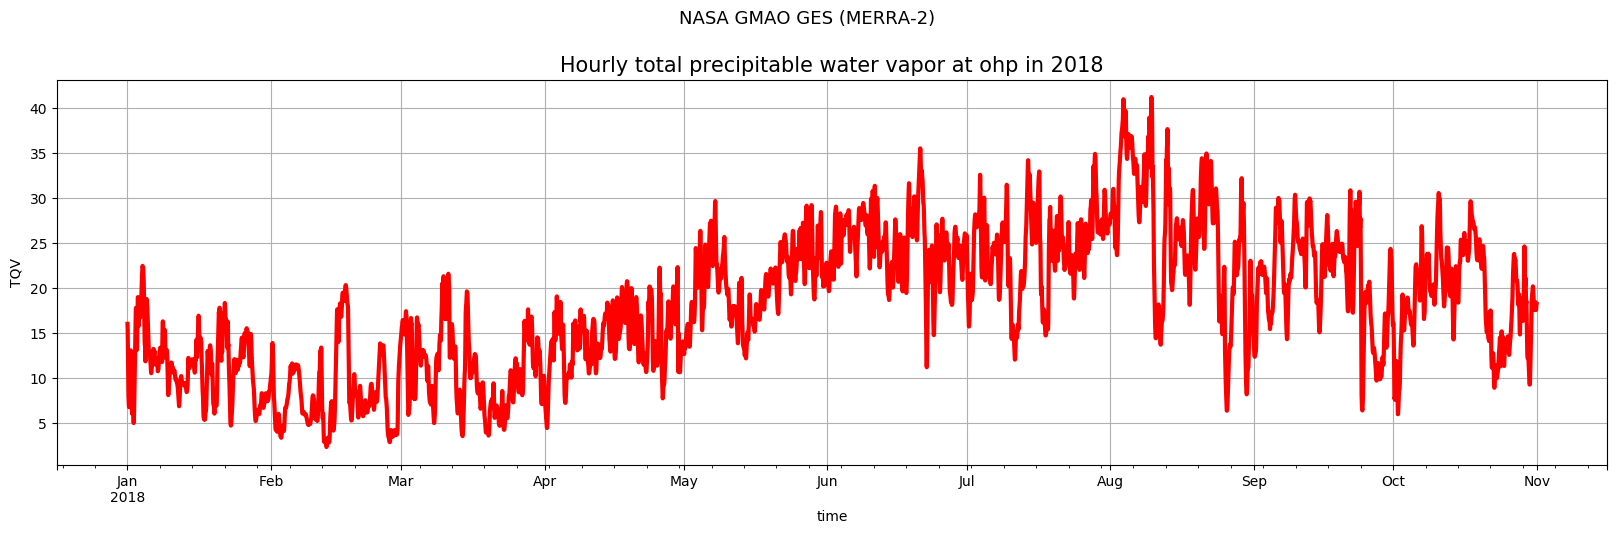

In [49]:
PlotTimeSeries(7,figfile_tqv)

### 4.8) TS

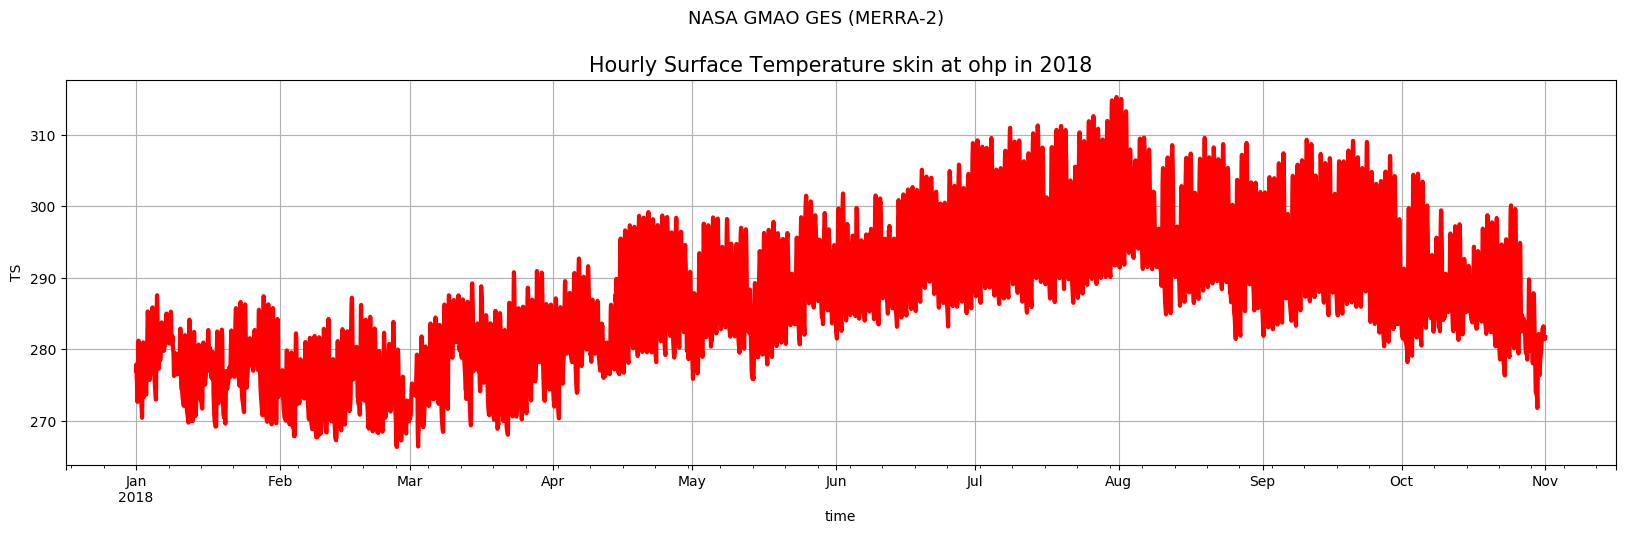

In [50]:
PlotTimeSeries(8,figfile_ts)

### 4.9) um10

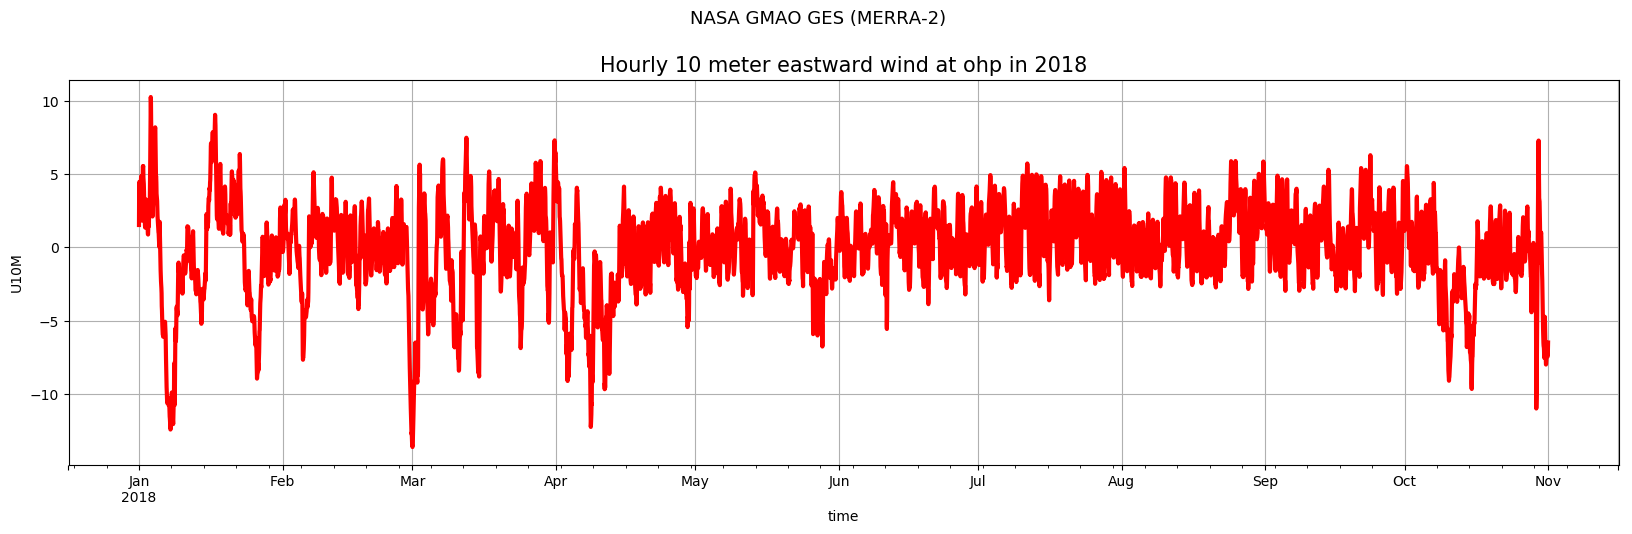

In [51]:
PlotTimeSeries(9,figfile_u10m)

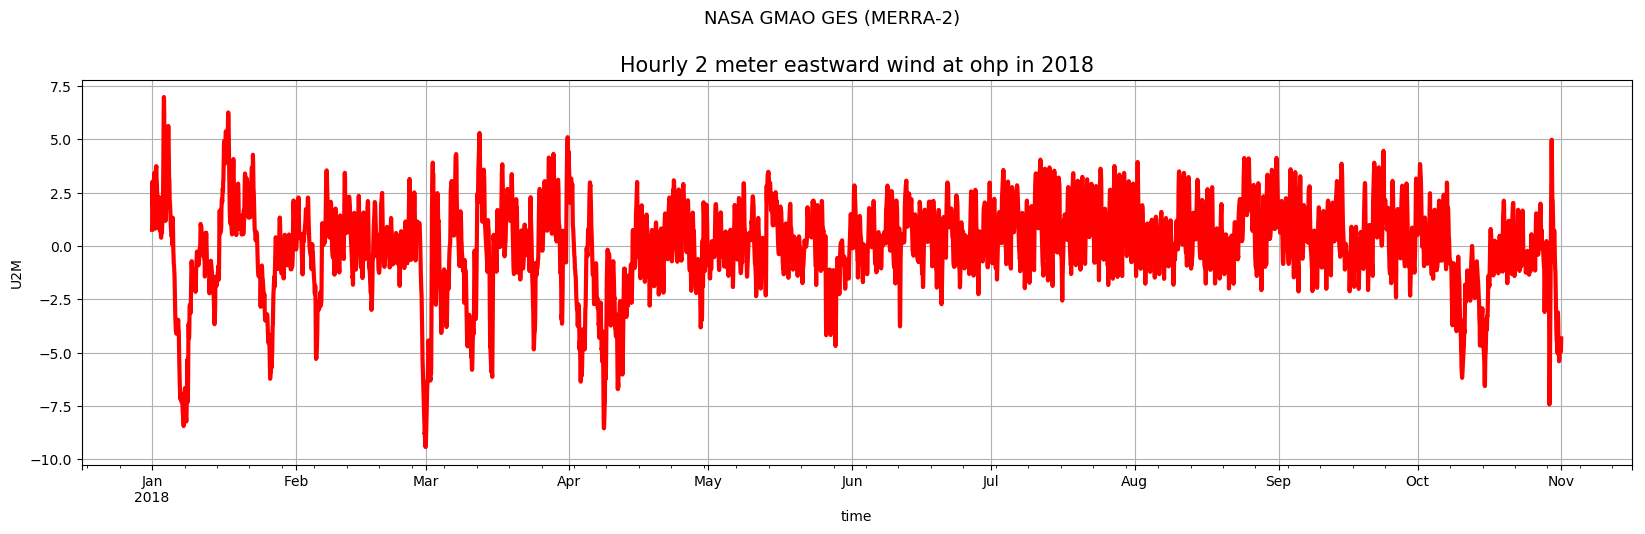

In [52]:
PlotTimeSeries(10,figfile_u2m)

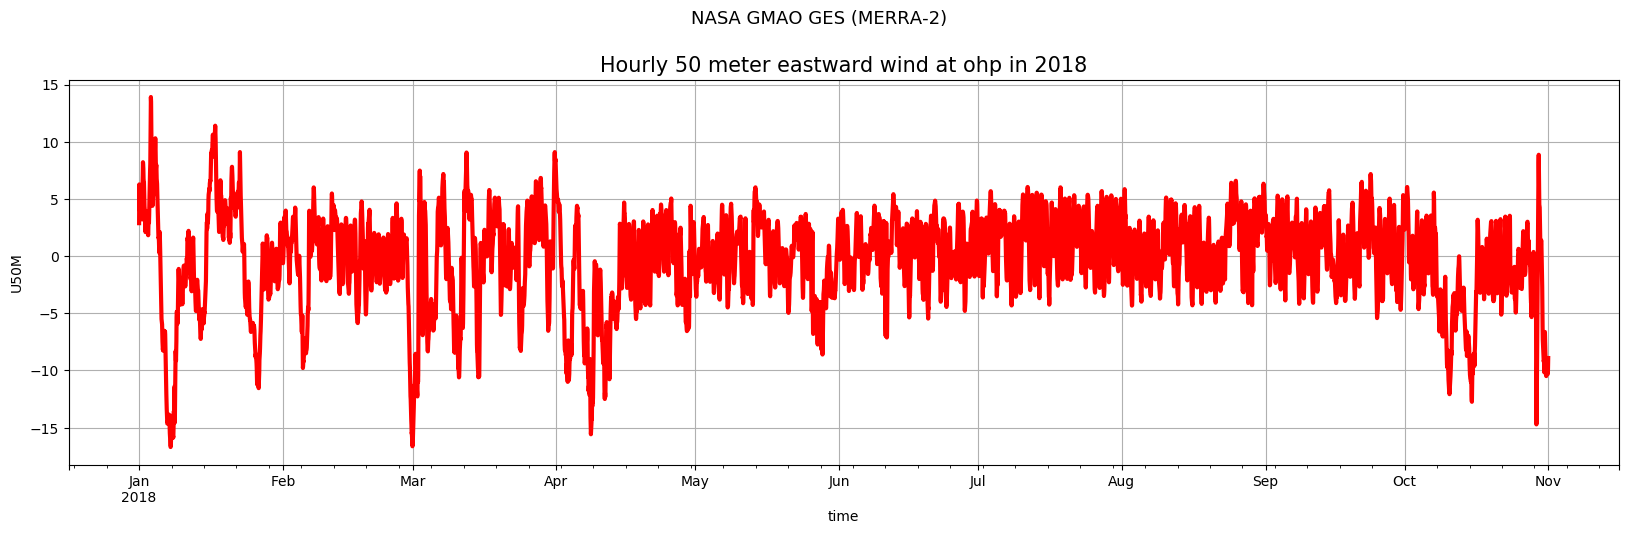

In [53]:
PlotTimeSeries(11,figfile_u50m)

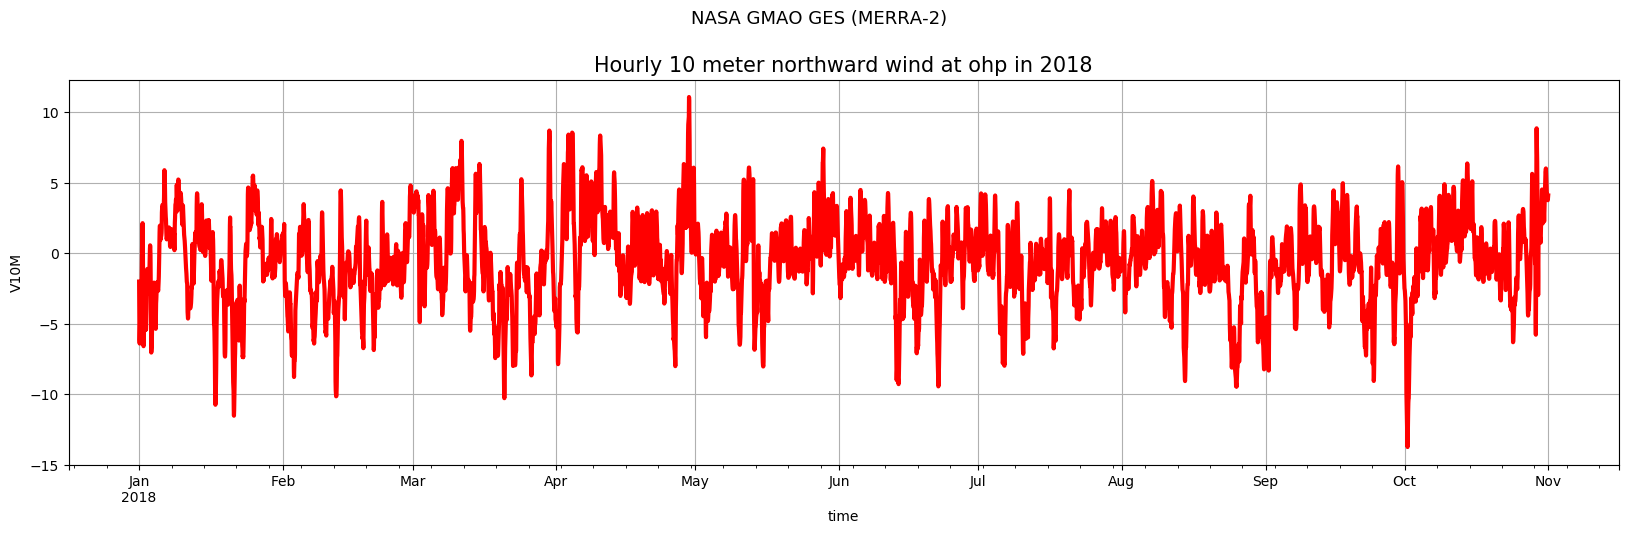

In [54]:
PlotTimeSeries(12,figfile_v10m)

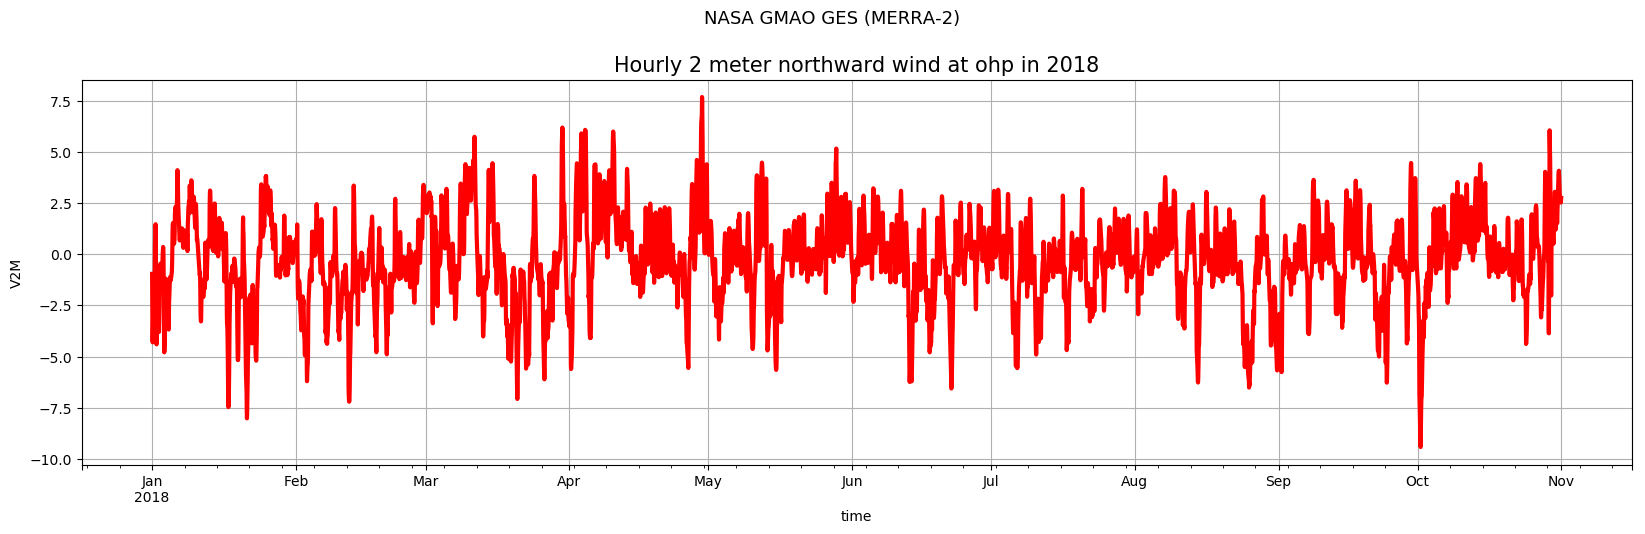

In [55]:
PlotTimeSeries(13,figfile_v2m)

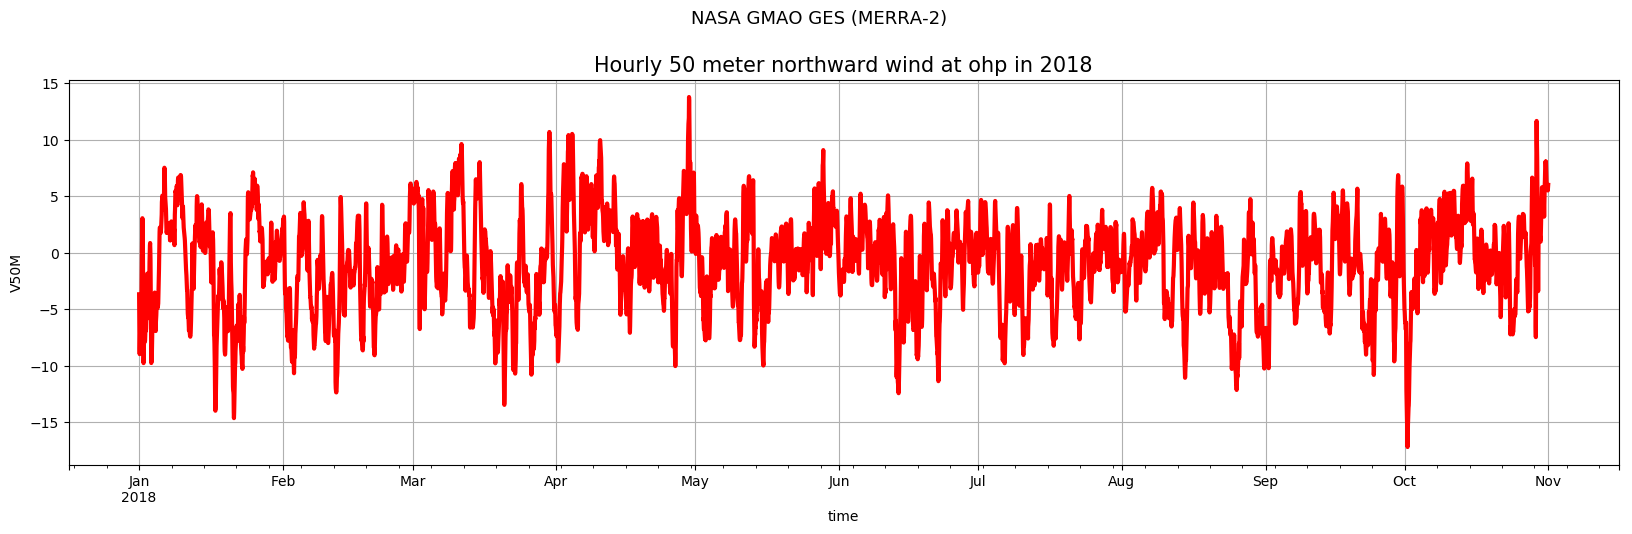

In [56]:
PlotTimeSeries(14,figfile_v50m)

## 5) Output

In [57]:
df_inst1_2d_asm_Nx.index.name='time'
df_inst1_2d_asm_Nx.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000
mean,93690.445312,287.242279,286.903503,333.103180,0.007147,0.020645,0.056873,18.180714,286.994690,-0.060914,0.013535,-0.282464,-0.558455,-0.307710,-0.906679
std,671.077942,8.320049,8.771563,42.701752,0.000915,0.041072,0.078178,7.634499,10.106508,2.975199,2.011381,4.015121,3.028243,2.070846,4.074852
min,90351.312500,266.681335,266.794922,243.074661,0.005227,0.000000,0.000000,2.350126,266.385925,-13.590304,-9.430898,-16.700460,-13.734650,-9.420718,-17.193630
25%,93411.529297,280.222000,279.989799,305.020294,0.006546,0.000064,0.001170,12.229868,279.614349,-1.648073,-0.898828,-2.435191,-2.202222,-1.215600,-3.352111
50%,93811.417969,287.847961,286.947906,324.279572,0.006958,0.002711,0.020298,18.162657,286.280289,0.247351,0.153364,0.242854,-0.485068,-0.285126,-0.687400
75%,94087.970703,293.373398,293.215431,359.312698,0.007708,0.022064,0.083557,24.187058,293.895569,1.874544,1.181431,2.566777,1.357951,0.851854,1.925327
max,95630.148438,307.667267,309.370941,476.769897,0.010235,0.507080,0.454712,41.252686,315.242340,10.241591,6.991255,13.905725,11.095821,7.683163,13.775771


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [58]:
dataset=df_inst1_2d_asm_Nx

In [59]:
dataset.index.name='time'

In [60]:
dataset.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000
mean,93690.445312,287.242279,286.903503,333.103180,0.007147,0.020645,0.056873,18.180714,286.994690,-0.060914,0.013535,-0.282464,-0.558455,-0.307710,-0.906679
std,671.077942,8.320049,8.771563,42.701752,0.000915,0.041072,0.078178,7.634499,10.106508,2.975199,2.011381,4.015121,3.028243,2.070846,4.074852
min,90351.312500,266.681335,266.794922,243.074661,0.005227,0.000000,0.000000,2.350126,266.385925,-13.590304,-9.430898,-16.700460,-13.734650,-9.420718,-17.193630
25%,93411.529297,280.222000,279.989799,305.020294,0.006546,0.000064,0.001170,12.229868,279.614349,-1.648073,-0.898828,-2.435191,-2.202222,-1.215600,-3.352111
50%,93811.417969,287.847961,286.947906,324.279572,0.006958,0.002711,0.020298,18.162657,286.280289,0.247351,0.153364,0.242854,-0.485068,-0.285126,-0.687400
75%,94087.970703,293.373398,293.215431,359.312698,0.007708,0.022064,0.083557,24.187058,293.895569,1.874544,1.181431,2.566777,1.357951,0.851854,1.925327
max,95630.148438,307.667267,309.370941,476.769897,0.010235,0.507080,0.454712,41.252686,315.242340,10.241591,6.991255,13.905725,11.095821,7.683163,13.775771


In [61]:
dataset.head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2018-01-01 00:00:00,93586.179688,279.042542,277.924255,306.891296,0.006579,0.002162,0.319946,16.039366,277.089447,1.527891,0.762904,2.875433,-1.997757,-0.959274,-3.679868
2018-01-01 01:00:00,93644.218750,278.965088,278.596436,308.947205,0.006623,0.002974,0.182983,15.441454,277.915039,4.309712,2.856233,6.262999,-4.501500,-2.982562,-6.735511
2018-01-01 02:00:00,93752.140625,277.812256,277.561188,311.975006,0.006688,0.018402,0.112579,13.318526,276.945557,4.463665,3.018662,5.803768,-6.118572,-4.138448,-8.414824
2018-01-01 03:00:00,93814.812500,277.139404,276.858215,315.935669,0.006773,0.024605,0.066193,11.264016,276.241669,3.333664,2.247162,4.378160,-6.393670,-4.307884,-8.974257
2018-01-01 04:00:00,93837.578125,276.814911,276.422668,322.490082,0.006913,0.004604,0.045456,9.346043,275.632324,2.848288,1.887254,3.963684,-5.576814,-3.692428,-8.323152


### write pandas

In [62]:
dataset.to_csv(pandas_filename)

### write hdf5

In [63]:
dataset.to_hdf(hdf5_filename,key='df',mode="w")

ImportError: HDFStore requires PyTables, "dlopen(/Users/dagoret/anaconda2/lib/python2.7/site-packages/tables/utilsextension.so, 2): Library not loaded: @rpath/libhdf5.101.dylib
  Referenced from: /Users/dagoret/anaconda2/lib/python2.7/site-packages/tables/utilsextension.so
  Reason: image not found" problem importing

### Check

In [64]:
saved_dataset=pd.read_csv(pandas_filename)

In [65]:
saved_dataset.head()

,time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
0,2018-01-01 00:00:00,93586.18,279.04254,277.92426,306.89130,0.006579,0.002162,0.319946,16.039366,277.08945,1.527891,0.762904,2.875433,-1.997757,-0.959274,-3.679868
1,2018-01-01 01:00:00,93644.22,278.96510,278.59644,308.94720,0.006623,0.002974,0.182983,15.441454,277.91504,4.309712,2.856233,6.262999,-4.501500,-2.982562,-6.735511
2,2018-01-01 02:00:00,93752.14,277.81226,277.56120,311.97500,0.006688,0.018402,0.112579,13.318526,276.94556,4.463664,3.018662,5.803768,-6.118572,-4.138448,-8.414824
3,2018-01-01 03:00:00,93814.81,277.13940,276.85822,315.93567,0.006773,0.024605,0.066193,11.264016,276.24167,3.333664,2.247162,4.378160,-6.393670,-4.307884,-8.974257
4,2018-01-01 04:00:00,93837.58,276.81490,276.42267,322.49008,0.006913,0.004604,0.045456,9.346043,275.63232,2.848288,1.887254,3.963684,-5.576814,-3.692428,-8.323152


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [66]:
table = Table.from_pandas(saved_dataset)

In [67]:
table

time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2018-01-01 00:00:00,93586.18,279.04254,277.92426,306.8913,0.006578864,0.0021619797,0.31994629999999996,16.039366,277.08945,1.5278912,0.7629037,2.8754332000000002,-1.9977574,-0.95927405,-3.6798677000000004
2018-01-01 01:00:00,93644.22,278.9651,278.59644,308.9472,0.006622923,0.0029735565,0.1829834,15.441454,277.91504,4.3097124,2.8562331000000003,6.2629985999999995,-4.5014997,-2.9825618,-6.735511
2018-01-01 02:00:00,93752.14,277.81226000000004,277.5612,311.975,0.0066878195,0.018402099999999998,0.112579346,13.318526,276.94556,4.463664499999999,3.0186622000000005,5.803767700000001,-6.118572,-4.138448,-8.4148245
2018-01-01 03:00:00,93814.81,277.1394,276.85822,315.93567,0.0067727063,0.024604797,0.06619263,11.264016,276.24167,3.3336644,2.2471619,4.37816,-6.393669999999999,-4.307884,-8.974257000000001
2018-01-01 04:00:00,93837.58,276.8149,276.42267000000004,322.49008,0.0069131340000000005,0.0046043396,0.045455933,9.346043,275.63232,2.848288,1.8872536,3.9636836000000004,-5.576813700000001,-3.6924279,-8.323152
2018-01-01 05:00:00,93866.42,276.02676,275.4928,327.53333,0.0070213927,0.00023192167,0.07336426,8.057005,274.52893,2.9512452999999996,1.8954362,4.603602400000001,-4.40557,-2.8262546000000004,-7.2163167
2018-01-01 06:00:00,93922.5,275.24062999999995,274.55615,331.24805,0.0071010888000000005,0.00024437904,0.07949829,7.4319954,273.4226,2.9554982000000005,1.8422169999999998,5.0693245000000005,-3.9313085,-2.4399580000000003,-7.102588000000001
2018-01-01 07:00:00,93975.055,274.70984,273.92303,334.64633,0.007173862,0.0001449585,0.0687561,7.0191479999999995,272.67812999999995,2.7430972999999996,1.6517979999999999,4.934481,-3.4946038999999995,-2.0873296000000003,-6.5915985
2018-01-01 08:00:00,93991.93,275.08762,274.4169,332.97556000000003,0.0071530226,0.00010752678,0.04727173,6.77795,273.92242000000005,2.5331373,1.5033611,4.4490989999999995,-2.9303489,-1.7230488999999998,-5.4172970000000005


In [68]:
table.write(fits_filename,format='fits',overwrite=True)